In [23]:
import numpy as np
import pandas as pd
import glob
import os
from scipy.interpolate import interp1d

# **1. 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2. 결측값 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **10V 데이터 추가 보간**
if 10 not in V_values:
    V_values = np.append(V_values, 10)
    t0_values = np.append(t0_values, t0_interp(10))
    mu_values = np.append(mu_values, mu_interp(10))

# **3. 실험 데이터 로드 및 비교**
data_list = []

L = 400  # μm (두께)

dat_files = sorted(glob.glob("*.dat"))  # 현재 폴더 내의 모든 *.dat 파일

for file in dat_files:
    # 파일 이름에서 V 값 추출
    V = float(os.path.basename(file).split("V")[0])
    
    if V not in V_values:
        continue  # fittings.csv에 없는 V는 건너뜀

    # 실험 데이터 로드
    exp_data = np.loadtxt(file, delimiter=",")
    z_exp, t_exp = exp_data[:, 0], exp_data[:, 1]

    # t0 실험값: z=0에 대응하는 최소 t
    t0_exp = np.min(t_exp) if len(t_exp) > 0 else np.nan

    # tf 실험값: z=L(=400μm)에 대응하는 최대 t
    tf_exp = np.max(t_exp) if len(t_exp) > 0 else np.nan

    # mu 이론값 및 실험값 비교
    idx = np.where(V_values == V)[0][0]
    t0_fit, mu_fit = t0_values[idx], mu_values[idx]
    tf_fit = t0_fit + (L**2) / (2 * V * mu_fit)  # 이론적인 tf

    # 에러바 계산 (절대값 차이)
    t0_error = abs(t0_exp - t0_fit) if not np.isnan(t0_exp) else np.nan
    tf_error = abs(tf_exp - tf_fit) if not np.isnan(tf_exp) else np.nan
    mu_error = abs(mu_fit - (L**2) / (2 * V * (tf_exp - t0_exp))) if not np.isnan(tf_exp) else np.nan

    # 데이터 저장
    data_list.append([V, mu_fit, mu_error, t0_fit, t0_error, tf_fit, tf_error])

# **4. CSV 저장**
output_df = pd.DataFrame(data_list, columns=["V", "mu", "mu_error", "t0", "t0_error", "tf", "tf_error"])
output_df.to_csv("error_analysis.csv", index=False)

print("결과가 error_analysis.csv 파일로 저장되었습니다.")


결과가 error_analysis.csv 파일로 저장되었습니다.


In [16]:
import numpy as np
import pandas as pd
import os
from scipy.interpolate import interp1d

# RMSE 계산 함수
def mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# R² (결정계수) 계산 함수
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

# **1. 데이터 로드 및 보간**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# NaN 값 보간 (선형 보간)
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **10V 데이터 추가 보간**
if 10 not in V_values:
    V_values = np.append(V_values, 10)
    t0_values = np.append(t0_values, t0_interp(10))
    mu_values = np.append(mu_values, mu_interp(10))

# **2. 원래 데이터 비교 및 RMSE 계산**
L = 400  # μm

results = []
for V, t0, mu in zip(V_values, t0_values, mu_values):
    file_name = f"{V:.1f}V-Tot-resized2.dat"
    if not os.path.exists(file_name):
        continue  # 파일 없으면 건너뛰기

    # 원래 데이터 로드
    exp_data = np.loadtxt(file_name, delimiter=",")
    z_exp, t_exp = exp_data[:, 0], exp_data[:, 1]

    # 모델 예측값 계산
    z_pred = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_exp - t0), 0))  # 음수 방지

    # RMSE 및 R² 계산
    rmse = mean_squared_error(z_exp, z_pred)
    r2 = r2_score(z_exp, z_pred)

    # **tf 값 계산**
    tf = t0 + (L**2) / (2 * V * mu)

    # **mu 오차 결정 (mu를 변화시켜 RMSE 증가 분석)**
    delta_mu = mu * 0.01  # 초기 변화량 (1% 증가)
    mu_varied = mu + delta_mu  # 변화된 mu 값
    z_pred_varied = L - np.sqrt(np.maximum(L**2 - 2 * V * mu_varied * (t_exp - t0), 0))  # 새로운 fitting 곡선

    # 새로운 RMSE 계산
    rmse_varied = mean_squared_error(z_exp, z_pred_varied)

    # RMSE 변화율을 기준으로 mu의 에러 결정
    mu_error = np.abs(delta_mu) if (rmse_varied - rmse) / rmse > 0.05 else np.abs(delta_mu / 2)  

    # **t0 및 tf 오차 계산 (기존 방식 유지)**
    N = len(t_exp)
    partial_dz_dt0 = np.abs((V * mu) / np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_exp - t0), 1e-8)))
    partial_dz_dtf = np.abs((V * mu) / np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_exp - tf), 1e-8)))

    t0_error = np.mean(partial_dz_dt0) * (rmse / np.sqrt(N))
    tf_error = np.mean(partial_dz_dtf) * (rmse / np.sqrt(N))

    # 결과 저장
    results.append([V, rmse, r2, mu, mu_error, t0, t0_error, tf, tf_error])

# **3. 결과 CSV 저장**
results_df = pd.DataFrame(results, columns=["V", "RMSE", "R2", "mu", "mu_error", "t0", "t0_error", "tf", "tf_error"])
results_df.to_csv("fitting_errors.csv", index=False)
print("CSV 파일 저장 완료: fitting_errors.csv")


CSV 파일 저장 완료: fitting_errors.csv


CSV 파일 저장 완료: fitting_errors2.csv


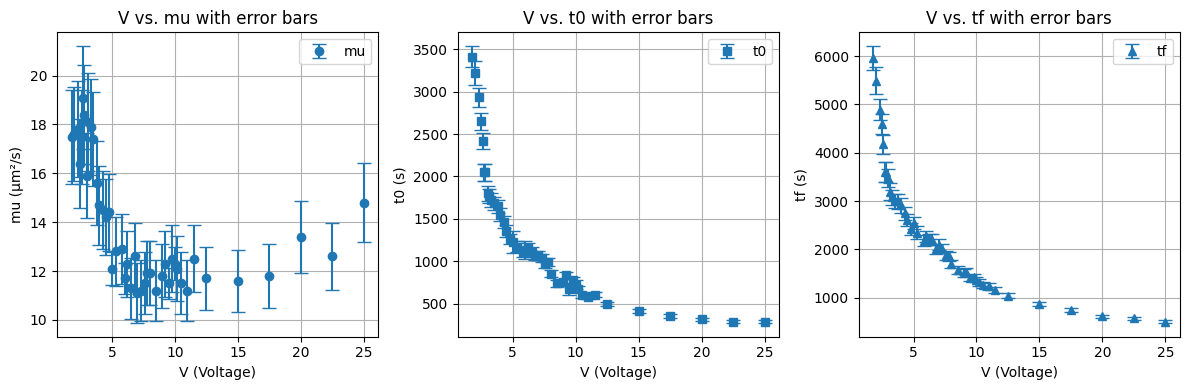

In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# RMSE 계산 함수
def mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# R² (결정계수) 계산 함수
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

# **1. 데이터 로드 및 보간**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# NaN 값 보간 (선형 보간)
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **10V 데이터 추가 보간**
if 10 not in V_values:
    V_values = np.append(V_values, 10)
    t0_values = np.append(t0_values, t0_interp(10))
    mu_values = np.append(mu_values, mu_interp(10))

# **2. 원래 데이터 비교 및 RMSE 계산**
L = 400  # μm

results = []
for V, t0, mu in zip(V_values, t0_values, mu_values):
    file_name = f"{V:.1f}V-Tot-resized2.dat"
    if not os.path.exists(file_name):
        continue  # 파일 없으면 건너뛰기

    # 원래 데이터 로드
    exp_data = np.loadtxt(file_name, delimiter=",")
    z_exp, t_exp = exp_data[:, 0], exp_data[:, 1]

    # 모델 예측값 계산
    z_pred = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_exp - t0), 0))  # 음수 방지

    # RMSE 및 R² 계산
    rmse = mean_squared_error(z_exp, z_pred)
    r2 = r2_score(z_exp, z_pred)

    # **tf 값 계산**
    tf = t0 + (L**2) / (2 * V * mu)

    # **mu 오차 결정 (mu 변화에 따른 RMSE 증가 분석)**
    delta_mu = mu * 0.11  # 초기 변화량 (1% 증가)
    mu_varied = mu + delta_mu  # 변화된 mu 값
    z_pred_varied = L - np.sqrt(np.maximum(L**2 - 2 * V * mu_varied * (t_exp - t0), 0))  

    rmse_varied = mean_squared_error(z_exp, z_pred_varied)
    mu_error = np.abs(delta_mu) if (rmse_varied - rmse) / rmse > 0.05 else np.abs(delta_mu / 2)  

    # **t0 오차 결정 (t0 변화에 따른 RMSE 분석)**
    delta_t0 = (t_exp.max() - t_exp.min()) * 0.11  # 초기 변화량 (1% 시간 변화)
    t0_varied = t0 + delta_t0
    z_pred_varied_t0 = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_exp - t0_varied), 0))

    rmse_varied_t0 = mean_squared_error(z_exp, z_pred_varied_t0)
    t0_error = np.abs(delta_t0) if (rmse_varied_t0 - rmse) / rmse > 0.05 else np.abs(delta_t0 / 2)

    # **tf 오차 결정 (tf 변화에 따른 RMSE 분석)**
    delta_tf = (t_exp.max() - t_exp.min()) * 0.11  
    tf_varied = tf + delta_tf
    z_pred_varied_tf = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_exp - tf_varied), 0))

    rmse_varied_tf = mean_squared_error(z_exp, z_pred_varied_tf)
    tf_error = np.abs(delta_tf) if (rmse_varied_tf - rmse) / rmse > 0.05 else np.abs(delta_tf / 2)

    # 결과 저장
    results.append([V, rmse, r2, mu, mu_error, t0, t0_error, tf, tf_error])

# **3. 결과 CSV 저장**
results_df = pd.DataFrame(results, columns=["V", "RMSE", "R2", "mu", "mu_error", "t0", "t0_error", "tf", "tf_error"])
results_df.to_csv("fitting_errors.csv", index=False)
print("CSV 파일 저장 완료: fitting_errors2.csv")

# **4. 그래프 플로팅**
plt.figure(figsize=(12, 4))

# **(1) V vs. mu (에러바 포함)**
plt.subplot(1, 3, 1)
plt.errorbar(results_df["V"], results_df["mu"], yerr=results_df["mu_error"], fmt="o", capsize=5, label="mu")
plt.xlabel("V (Voltage)")
plt.ylabel("mu (μm²/s)")
plt.title("V vs. mu with error bars")
plt.grid(True)
plt.legend()

# **(2) V vs. t0 (에러바 포함)**
plt.subplot(1, 3, 2)
plt.errorbar(results_df["V"], results_df["t0"], yerr=results_df["t0_error"], fmt="s", capsize=5, label="t0")
plt.xlabel("V (Voltage)")
plt.ylabel("t0 (s)")
plt.title("V vs. t0 with error bars")
plt.grid(True)
plt.legend()

# **(3) V vs. tf (에러바 포함)**
plt.subplot(1, 3, 3)
plt.errorbar(results_df["V"], results_df["tf"], yerr=results_df["tf_error"], fmt="^", capsize=5, label="tf")
plt.xlabel("V (Voltage)")
plt.ylabel("tf (s)")
plt.title("V vs. tf with error bars")
plt.grid(True)
plt.legend()

# **그래프 저장 및 표시**
plt.tight_layout()
plt.savefig("fitting_error_plots.png", dpi=300)
plt.show()
